# Import Data

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_csv('Solid_waste_audit_Solomon_Islands_Abundance.csv', index_col='RecordID').reset_index()
df.Site.value_counts()

Guadalcanal        31781
Honiara            15482
Arabella           11843
Kilusakwalo         9531
Ambu                8180
Auki Commercial     2400
Ship                 600
Name: Site, dtype: int64

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99437 entries, 0 to 99436
Data columns (total 16 columns):
RecordID                      99437 non-null int64
UniqueID                      99437 non-null int64
Commercial                    5400 non-null float64
Date                          6007 non-null object
HouseholdCommercialShip_ID    99437 non-null object
Item                          99437 non-null object
Material                      98244 non-null object
Measure                       99437 non-null object
Multiplier                    99437 non-null float64
Nation                        99437 non-null object
RecordDate                    99437 non-null object
Site                          79817 non-null object
Size                          58995 non-null object
Sorter                        0 non-null float64
Type                          3000 non-null object
Value                         99437 non-null float64
dtypes: float64(4), int64(2), object(10)
memory usage: 12.1+ MB


In [3]:
for column in df.columns:
    print(f'{column} - Value Counts:')
    print(df[column].value_counts(normalize=True, dropna=False).head(10))
    print(f'Unique values: {df[column].nunique()}')
    print('--------------------------------------')

RecordID - Value Counts:
148    0.007321
140    0.007321
142    0.007311
144    0.007301
138    0.007301
174    0.007291
164    0.007291
166    0.007291
134    0.007291
168    0.007291
Name: RecordID, dtype: float64
Unique values: 327
--------------------------------------
UniqueID - Value Counts:
46370    0.00002
11151    0.00002
45916    0.00002
39769    0.00002
26223    0.00002
60247    0.00002
58198    0.00002
62292    0.00002
66450    0.00002
50509    0.00002
Name: UniqueID, dtype: float64
Unique values: 80701
--------------------------------------
Commercial - Value Counts:
NaN     0.945694
 1.0    0.054306
Name: Commercial, dtype: float64
Unique values: 1
--------------------------------------
Date - Value Counts:
NaN           0.93959
12/05/2018    0.06041
Name: Date, dtype: float64
Unique values: 1
--------------------------------------
HouseholdCommercialShip_ID - Value Counts:
AH01_Sol    0.005752
C16_Sol     0.004445
S02_Sol     0.004435
H15_Sol     0.004435
H03_Sol     0.0

# Data Cleaning

## Drop Features

In [4]:
df = df.drop(['UniqueID',
         'Date',
         'Multiplier',
         'Nation',
         'Size',
         'Sorter',
         'Type'], axis=1)

In [5]:
df.head()

RecordID  Commercial HouseholdCommercialShip_ID                      Item Material Measure           RecordDate             Site  Value
0       212         NaN                   AC01_Sol  Total sample weight (KG)      NaN  Weight  12/07/2018 00:00:00  Auki Commercial  3.948
1       212         NaN                   AC01_Sol           Wet weight (KG)      NaN  Weight  12/07/2018 00:00:00  Auki Commercial  0.000
2       212         NaN                   AC01_Sol           Dry weight (KG)      NaN  Weight  12/07/2018 00:00:00  Auki Commercial  0.000
3       212         NaN                   AC01_Sol            Aluminium cans    Metal  Weight  12/07/2018 00:00:00  Auki Commercial  0.000
4       212         NaN                   AC01_Sol            Aluminium cans    Metal   Count  12/07/2018 00:00:00  Auki Commercial  0.000

## Remove Uncollected Items 

In [6]:
#Remove rows without a value to only leave items actually collected per household
df = df[df.Value > 0]
df = df[df.Item != 'Total sample weight (KG)']
df.Commercial = df.Commercial.fillna(0)
df = df[df['Commercial'] == 0]
print(f'There are {len(df)} records remaining in the filtered dataset')

There are 5197 records remaining in the filtered dataset


## Determine Which Measure is most Accurate 

In [7]:
for measure in df.Measure.unique():
    print(f'There are {len(df[df.Measure == measure])} rows with the measure:', measure)

There are 1550 rows with the measure: Weight
There are 2128 rows with the measure: Count
There are 1519 rows with the measure: Volume


**Okay so we see that the measure used the most is weight, this is good as it provides the kg metric that we need to do our future calculations.  The summary of this undertaking written by CEFAS explains that 'Beverage containers were sorted and counted separately', though it does not state why.  It is clear looking at the value counts below that all items with an 'ml' in them only appear a few times as they are not repeated with the measure of 'weight' or 'volume' at all.**

**For now, let's leave out 'count' and 'volume' and continue with 'weight'.**

In [8]:
df = df[df.Measure == 'Weight']
df.head()

RecordID  Commercial HouseholdCommercialShip_ID            Item             Material Measure           RecordDate             Site  Value
24       212         0.0                   AC01_Sol       Cardboard  Paper and cardboard  Weight  12/07/2018 00:00:00  Auki Commercial  0.060
33       212         0.0                   AC01_Sol           Paper  Paper and cardboard  Weight  12/07/2018 00:00:00  Auki Commercial  0.184
42       212         0.0                   AC01_Sol             EPS              Plastic  Weight  12/07/2018 00:00:00  Auki Commercial  0.130
45       212         0.0                   AC01_Sol    Plastic bags              Plastic  Weight  12/07/2018 00:00:00  Auki Commercial  0.165
54       212         0.0                   AC01_Sol  Flexibles/Film              Plastic  Weight  12/07/2018 00:00:00  Auki Commercial  0.336

## Item Feature Cleaning

## Remove Low Occurring Items (< 10)

In [9]:
df['Item'].value_counts(ascending=True, dropna=False)

Hazardous                                        1
Plastic oil containers                           1
Mobile phones                                    1
Fishing/ seafood plastic                         1
Feminine hygiene                                 1
Used lead acid batteries                         1
Lithium Batteries                                1
Glass fines                                      1
Toner cartridges                                 2
Medical waste                                    2
Glass bottles win and spirt                      2
Wood/timber                                      3
Glass bottles CDS                                3
Cigarette butts                                  3
Ceramics                                         4
Other sanitary waste                             6
HDPE bottles                                     6
Metal other                                      6
Electrical items and peripherals (incl TVs)      8
Glass other                    

In [10]:
def items_to_drop(min_num, df):
    '''
    DocString!!!!
    '''
    drop_df = pd.DataFrame()
    
    drop_df['Items'] = df['Item'].value_counts(ascending=True, dropna=False).index
    drop_df['Count'] = df['Item'].value_counts(ascending=True, dropna=False).values
    
    drop_list = drop_df[drop_df['Count'] < min_num]['Items'].values
    
    return drop_list

In [11]:
drop_items= items_to_drop(10, df)
df['Item'] = df['Item'].map(lambda x:'drop' if x in drop_items else x)
df = df[df['Item'] != 'drop']
df['Item'].value_counts()

Flexibles/Film          198
Aluminium cans          175
Plastic bags            158
Food                    136
PET bottles             117
Steel cans              113
Other plastic           108
Cardboard               105
Other organics          102
Paper                    62
EPS                      47
Textles                  42
Other                    27
PP                       20
Nappies                  18
LPB                      17
Glass Jars               16
Aluminium recyclable     15
Other batteries          12
Name: Item, dtype: int64

### Most Frequent Items by Weight

In [12]:
df[df.Measure == 'Weight'].groupby("Item").sum()

RecordID  Commercial     Value
Item                                                
Aluminium cans           21584         0.0  174.3520
Aluminium recyclable      1904         0.0    7.8650
Cardboard                13278         0.0   59.0770
EPS                       5832         0.0    4.6250
Flexibles/Film           25942         0.0   65.0456
Food                     19378         0.0  642.2182
Glass Jars                2647         0.0   15.0520
LPB                       2315         0.0    3.4930
Nappies                   1911         0.0   68.2870
Other                     3702         0.0   17.9900
Other batteries           1465         0.0    2.2840
Other organics           10421         0.0  656.9690
Other plastic            12898         0.0   17.4450
PET bottles              13874         0.0   54.6820
PP                        3198         0.0    1.8640
Paper                     9851         0.0   18.5400
Plastic bags             18533         0.0   71.2350
Steel cans               12360         0.0   87.6050
Textles                   5089         0.0   54.9120

## Rename 'Other' Items by Material Given

In [13]:
for material in df.Material.unique():
    print(f'{material} Value Counts:')
    print(df[df['Material'] == material]['Item'].value_counts())
    print('----------------------------------')

Paper and cardboard Value Counts:
Cardboard    105
Paper         62
LPB           17
Name: Item, dtype: int64
----------------------------------
Plastic Value Counts:
Flexibles/Film    198
Plastic bags      158
PET bottles       117
Other plastic     108
EPS                47
PP                 20
Name: Item, dtype: int64
----------------------------------
Glass Value Counts:
Glass Jars    16
Name: Item, dtype: int64
----------------------------------
Organics Value Counts:
Food              136
Other organics    102
Name: Item, dtype: int64
----------------------------------
Other Value Counts:
Textles    42
Other      27
Name: Item, dtype: int64
----------------------------------
Metal Value Counts:
Aluminium cans          175
Steel cans              113
Aluminium recyclable     15
Name: Item, dtype: int64
----------------------------------
Hygiene Value Counts:
Nappies    18
Name: Item, dtype: int64
----------------------------------
Batteries Value Counts:
Other batteries    12
Nam

In [14]:
# df.reset_index(drop=True, inplace=True)

# for material in df.Material.unique():
#     mat_items = df[df['Material'] == material]['Item'].value_counts().index
#     for item in mat_items.values:
#         if item == 'other':
#             mat_idxs = df[(df['Material'] == material) & (df['Item'] == item)].index
#             for idx in mat_idxs.values:
#                 df.iloc[idx, df.columns.get_loc('Item')] = f'other_{material}'
                
# for material in df.Material.unique():
#     print(f'{material} Value Counts:')
#     print(df[df.Material == material]['Item'].value_counts().head())
#     print('---------------------------------')

# Feature Engineering

## Total Weight per Household

**Now lets make a quick list showing all of the total waste collected per house ID.  This will be useful later after we have transformed the dataset to reflect one row per household.**

In [15]:
total_sample_df = pd.DataFrame()
total_sample_df['RecordID'] = df['RecordID'].sort_values().unique()
total_sample_df['Total_weight (kg)'] = df.groupby('RecordID').sum()['Value'].values
total_sample_df

RecordID  Total_weight (kg)
0           1             4.9480
1           2             7.2220
2           3            12.0320
3           4             0.4520
4           5            10.8480
5           6            10.5480
6           7             2.5016
7           8             3.4140
8           9             2.1800
9          10            16.6360
10         11             2.9360
11         12             3.5320
12         13             6.6920
13         14             4.4000
14         15             6.2380
15         16            16.6920
16         17            11.6840
17         18            10.4080
18         19            16.6120
19         20             0.9820
20         22            11.9280
21         23             6.7000
22         24            34.2920
23         25            24.7400
24         26            16.8720
25         27             8.4320
26         28            22.0660
27         29            13.3620
28         30            19.6280
29         31             4.8720
30         32             2.9760
31         33            22.3420
32         34            11.0720
33         35             5.0580
34         36             3.6360
35         37             5.6200
36         38            22.0460
37         39            14.4460
38         40             7.7240
39         41             3.0360
40         42            18.2940
41         43             9.5480
42         44            15.7040
43         45            21.5420
44         46             3.3360
45         47            27.6120
46         48             7.0840
47         49            17.2600
48         50            16.5340
49         51            16.0200
50         52            12.5100
51         53            10.6360
52         54             8.2680
53         55             7.9720
54         56             4.4340
55         57             5.6000
56         58             8.1500
57         59             9.5500
58         60             8.7800
59         61            10.3120
60         62             7.5500
61         63             9.5440
62         64             6.7820
63         65             1.4820
64         66            11.5260
65         67             2.7080
66         68             9.7640
67         69             6.4720
68         70            11.4080
69         71            23.1320
70         72            12.2080
71         73            18.2920
72         74            14.3400
73         75            37.3260
74         76             9.2920
75         77             4.5560
76         78            11.2280
77         79             7.4480
78         80            17.7060
79         81             1.3160
80         82             0.7780
81         83             0.1880
82         84             1.2040
83         85             0.6440
84         86             2.1920
85         87             0.3680
86         88             2.0280
87         89             4.1280
88         90             2.3600
89         91             0.2560
90         92             5.5200
91         93             1.1080
92         94             3.0280
93         95            11.6040
94         96             4.8120
95         97             6.8360
96         98             2.2080
97         99             1.7380
98        100             4.1360
99        101             0.9960
100       102             4.5920
101       103             0.2620
102       104            15.7080
103       105             5.2120
104       106             6.2480
105       107             0.8960
106       108            13.7740
107       109             4.0600
108       110             7.7920
109       111             8.8000
110       112             5.1960
111       113             0.3360
112       114            13.3680
113       115             0.4800
114       116             8.6080
115       117             4.2200
116       118             2.6160
117       119             2.1540
118       120             5.5520
119       121             6.0560
120       12

## Consolidate Materials for Composition Calculations

In [16]:
df_comp = df.reset_index(drop=True)
df_comp.Material.value_counts()

Plastic                648
Metal                  303
Organics               238
Paper and cardboard    184
Other                   69
Hygiene                 18
Glass                   16
Batteries               12
Name: Material, dtype: int64

In [17]:
df_comp[df_comp['Material'] == 'Other']['Item'].value_counts()

Textles    42
Other      27
Name: Item, dtype: int64

In [18]:
# Here we are grouping 'textiles' under the paper_and_cardboard for simplicity
for idx in df_comp[df_comp['Item'] == 'Textles'].index:
    df_comp.iloc[idx, df_comp.columns.get_loc('Material')] = 'Paper and cardboard'
df_comp[df_comp['Material'] == 'Other']['Item'].value_counts()

Other    27
Name: Item, dtype: int64

In [19]:
non_combust_list = ['Metal', 'Glass', 'E-Waste', 'Batteries', 'Other']
# Consolidate all non combustable material types into one
df_comp['Material'] = df_comp['Material'].map(lambda x: 'Non_combust' if x in non_combust_list else x)
# Here we are going to bring the 'hygiene' materials under the organics category for simplicity.
df_comp.Material = df_comp.Material.map(lambda x: 'Organics' if x == 'Hygiene' else x)
df_comp['Material'].value_counts()

Plastic                648
Non_combust            358
Organics               256
Paper and cardboard    226
Name: Material, dtype: int64

**Excellent! Now we can get a feel for the composition of each household's waste and from there generate its energy potential through the Plasma Arc Gasification process.**

In [20]:
#The only important column here is "Value", ignore the rest.
df_comp.reset_index(drop=True, inplace=True)
df_comp.groupby(['RecordID', 'Material']).sum()

Commercial    Value
RecordID Material                                
1        Non_combust                 0.0   0.9060
         Organics                    0.0   3.7840
         Paper and cardboard         0.0   0.1080
         Plastic                     0.0   0.1500
2        Non_combust                 0.0   1.2320
         Organics                    0.0   5.6200
         Plastic                     0.0   0.3700
3        Non_combust                 0.0   0.4520
         Organics                    0.0  11.1840
         Paper and cardboard         0.0   0.2480
         Plastic                     0.0   0.1480
4        Organics                    0.0   0.4320
         Plastic                     0.0   0.0200
5        Organics                    0.0  10.6320
         Plastic                     0.0   0.2160
6        Non_combust                 0.0   0.0160
         Organics                    0.0  10.4840
         Plastic                     0.0   0.0480
7        Non_combust                 0.0   0.3720
         Organics                    0.0   0.6280
         Paper and cardboard         0.0   0.3640
         Plastic                     0.0   1.1376
8        Organics                    0.0   3.2600
         Plastic                     0.0   0.1540
9        Non_combust                 0.0   0.3280
         Organics                    0.0   1.0120
         Plastic                     0.0   0.8400
10       Non_combust                 0.0   0.9160
         Organics                    0.0  13.4760
         Paper and cardboard         0.0   1.8440
         Plastic                     0.0   0.4000
11       Non_combust                 0.0   0.7840
         Organics                    0.0   1.9840
         Plastic                     0.0   0.1680
12       Non_combust                 0.0   1.0040
         Organics                    0.0   2.2200
         Paper and cardboard         0.0   0.0120
         Plastic                     0.0   0.2960
13       Non_combust                 0.0   0.2080
         Organics                    0.0   6.2040
         Paper and cardboard         0.0   0.0280
         Plastic                     0.0   0.2520
14       Non_combust                 0.0   4.1160
         Plastic                     0.0   0.2840
15       Non_combust                 0.0   0.1860
         Organics                    0.0   5.4880
         Paper and cardboard         0.0   0.1360
         Plastic                     0.0   0.4280
16       Non_combust                 0.0   0.1480
         Organics                    0.0  14.2320
         Paper and cardboard         0.0   1.8400
         Plastic                     0.0   0.4720
17       Non_combust                 0.0   0.3260
         Organics                    0.0  10.9760
         Plastic                     0.0   0.3820
18       Organics                    0.0  10.3600
         Plastic                     0.0   0.0480
19       Non_combust                 0.0   0.1640
         Organics                    0.0  16.2040
         Paper and cardboard         0.0   0.1360
         Plastic                     0.0   0.1080
20       Non_combust                 0.0   0.1400
         Organics                    0.0   0.6660
         Plastic                     0.0   0.1760
22       Non_combust                 0.0   0.6820
         Organics                    0.0   9.6360
         Paper and cardboard         0.0   0.1700
         Plastic                     0.0   1.4400
23       Non_combust                 0.0   2.3880
         Organics                    0.0   1.5280
         Paper and cardboard         0.0   1.9320
         Plastic                     0.0   0.8520
24       Non_combust                 0.0  11.1160
         Organics                    0.0  18.5880
         Paper and cardboard         0.0   1.5760
         Plastic                     0.0   3.0120
25       Organics                    0.0  24.6120
         Plastic                     0.0   0.1280
26       Organics             

In [21]:
#Bring all of the composition data into a dictionary
house_comp_list = {}
for idx in df_comp.RecordID.unique():
    house_comp_list[idx] = df_comp[df_comp.RecordID == idx].groupby(['RecordID', 'Material']).sum()['Value']/df_comp[df_comp.RecordID == idx].groupby(['RecordID', 'Material']).sum()['Value'].sum()
house_comp_list

{212: RecordID  Material           
 212       Non_combust            0.033418
           Organics               0.715949
           Paper and cardboard    0.065570
           Plastic                0.185063
 Name: Value, dtype: float64, 116: RecordID  Material   
 116       Non_combust    0.019517
           Organics       0.977695
           Plastic        0.002788
 Name: Value, dtype: float64, 117: RecordID  Material           
 117       Non_combust            0.083412
           Organics               0.888152
           Paper and cardboard    0.009479
           Plastic                0.018957
 Name: Value, dtype: float64, 118: RecordID  Material           
 118       Non_combust            0.077982
           Organics               0.899083
           Paper and cardboard    0.015291
           Plastic                0.007645
 Name: Value, dtype: float64, 231: RecordID  Material   
 231       Non_combust    0.019209
           Organics       0.980791
 Name: Value, dtype: float64,

In [22]:
house_comp_list[1].keys().levels[1]

Index(['Non_combust', 'Organics', 'Paper and cardboard', 'Plastic'], dtype='object', name='Material')

In [23]:
# Create a new dataframe by extracting the appropriate information from above.
# This dataframe will be composed of waste type by wt %

df_comp_final = pd.DataFrame()
non_combust_list = []
organics_list = []
paper_list = []
plastic_list = []

for idx in df_comp.RecordID.sort_values().unique():
        if len(house_comp_list[idx].keys().levels[1]) == 4 and house_comp_list[idx].keys().levels[1][0] == 'Non_combust': 
            non_combust_list.append(house_comp_list[idx][0])
        elif len(house_comp_list[idx].keys().levels[1]) == 3 and house_comp_list[idx].keys().levels[1][0] == 'Non_combust':
            non_combust_list.append(house_comp_list[idx][0])
        elif len(house_comp_list[idx].keys().levels[1]) == 2 and house_comp_list[idx].keys().levels[1][0] == 'Non_combust':
            non_combust_list.append(house_comp_list[idx][0])
        elif len(house_comp_list[idx].keys().levels[1]) == 1 and house_comp_list[idx].keys().levels[1][0] == 'Non_combust':
            non_combust_list.append(house_comp_list[idx][0])
        else:
            non_combust_list.append(0)

for idx in df_comp.RecordID.sort_values().unique():
    if idx == 1:
        organics_list.append(house_comp_list[idx][0])
    else:
        if len(house_comp_list[idx].keys().levels[1]) == 4 and house_comp_list[idx].keys().levels[1][1] == 'Organics': 
            organics_list.append(house_comp_list[idx][1])
        elif len(house_comp_list[idx].keys().levels[1]) == 3 and house_comp_list[idx].keys().levels[1][1] == 'Organics':
            organics_list.append(house_comp_list[idx][1])
        elif len(house_comp_list[idx].keys().levels[1]) == 3 and house_comp_list[idx].keys().levels[1][0] == 'Organics':
            organics_list.append(house_comp_list[idx][0])
        elif len(house_comp_list[idx].keys().levels[1]) == 2 and house_comp_list[idx].keys().levels[1][1] == 'Organics':
            organics_list.append(house_comp_list[idx][1])
        elif len(house_comp_list[idx].keys().levels[1]) == 2 and house_comp_list[idx].keys().levels[1][0] == 'Organics':
            organics_list.append(house_comp_list[idx][0])
        elif len(house_comp_list[idx].keys().levels[1]) == 1 and house_comp_list[idx].keys().levels[1][0] == 'Organics':
            organics_list.append(house_comp_list[idx][0])
        else:
            organics_list.append(0)
        
for idx in df_comp.RecordID.sort_values().unique():
#     if idx == 1 :
#         paper_list.append(house_comp_list[idx][1][1])
#     elif idx == 2 :
#         paper_list.append(house_comp_list[idx][2][2])
#     else:
    if len(house_comp_list[idx].keys().levels[1]) == 4 and house_comp_list[idx].keys().levels[1][2] == 'Paper and cardboard':
        paper_list.append(house_comp_list[idx][2])
    elif len(house_comp_list[idx].keys().levels[1]) == 3 and house_comp_list[idx].keys().levels[1][2] == 'Paper and cardboard':
        paper_list.append(house_comp_list[idx][2])
    elif len(house_comp_list[idx].keys().levels[1]) == 3 and house_comp_list[idx].keys().levels[1][1] == 'Paper and cardboard':
        paper_list.append(house_comp_list[idx][1])        
    elif len(house_comp_list[idx].keys().levels[1]) == 2 and house_comp_list[idx].keys().levels[1][1] == 'Paper and cardboard':
        paper_list.append(house_comp_list[idx][1])
    elif len(house_comp_list[idx].keys().levels[1]) == 2 and house_comp_list[idx].keys().levels[1][0] == 'Paper and cardboard':
        paper_list.append(house_comp_list[idx][0])
    elif len(house_comp_list[idx].keys().levels[1]) == 1 and house_comp_list[idx].keys().levels[1][0] == 'Paper and cardboard':
        paper_list.append(house_comp_list[idx][0])
    else:
        paper_list.append(0)
    
for idx in df_comp.RecordID.sort_values().unique():
    if idx == 2 :
        plastic_list.append(house_comp_list[idx][2][2])
    elif idx == 3 :
        plastic_list.append(house_comp_list[idx][3][3])
    else:
        if len(house_comp_list[idx].keys().levels[1]) == 4 and house_comp_list[idx].keys().levels[1][3] == 'Plastic':
            plastic_list.append(house_comp_list[idx][3])
        elif len(house_comp_list[idx].keys().levels[1]) == 3 and house_comp_list[idx].keys().levels[1][2] == 'Plastic':
            plastic_list.append(house_comp_list[idx][2])
        elif len(house_comp_list[idx].keys().levels[1]) == 2 and house_comp_list[idx].keys().levels[1][1] == 'Plastic':
            plastic_list.append(house_comp_list[idx][1])
        elif len(house_comp_list[idx].keys().levels[1]) == 1 and house_comp_list[idx].keys().levels[1][0] == 'Plastic':
            plastic_list.append(house_comp_list[idx][0])
        else:
            plastic_list.append(0) 

print(organics_list[166])            
            
df_comp_final['ID'] = df_comp.RecordID.sort_values().unique()
df_comp_final['Organics_wt_%'] = organics_list
df_comp_final['Paper_and_cardboard_wt_%'] = paper_list
df_comp_final['Plastics_wt_%'] = plastic_list
df_comp_final['Non_combust_wt_%'] = non_combust_list
df_comp_final = pd.concat([df_comp_final, total_sample_df.drop('RecordID', axis=1)], axis=1)
df_comp_final

0


ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight (kg)
0      1       0.183104                  0.021827       0.030315          0.183104             4.9480
1      2       0.778178                  0.000000       0.051232          0.170590             7.2220
2      3       0.929521                  0.020612       0.012301          0.037566            12.0320
3      4       0.955752                  0.000000       0.044248          0.000000             0.4520
4      5       0.980088                  0.000000       0.019912          0.000000            10.8480
5      6       0.993932                  0.000000       0.004551          0.001517            10.5480
6      7       0.251039                  0.145507       0.454749          0.148705             2.5016
7      8       0.954892                  0.000000       0.045108          0.000000             3.4140
8      9       0.464220                  0.000000       0.385321          0.150459             2.1800
9     10       0.810050                  0.110844       0.024044          0.055061            16.6360
10    11       0.675749                  0.000000       0.057221          0.267030             2.9360
11    12       0.628539                  0.003398       0.083805          0.284258             3.5320
12    13       0.927077                  0.004184       0.037657          0.031082             6.6920
13    14       0.000000                  0.000000       0.064545          0.935455             4.4000
14    15       0.879769                  0.021802       0.068612          0.029817             6.2380
15    16       0.852624                  0.110232       0.028277          0.008867            16.6920
16    17       0.939404                  0.000000       0.032694          0.027901            11.6840
17    18       0.995388                  0.000000       0.004612          0.000000            10.4080
18    19       0.975439                  0.008187       0.006501          0.009872            16.6120
19    20       0.678208                  0.000000       0.179226          0.142566             0.9820
20    22       0.807847                  0.014252       0.120724          0.057176            11.9280
21    23       0.228060                  0.288358       0.127164          0.356418             6.7000
22    24       0.542051                  0.045958       0.087834          0.324157            34.2920
23    25       0.994826                  0.000000       0.005174          0.000000            24.7400
24    26       0.997155                  0.000000       0.002845          0.000000            16.8720
25    27       0.958254                  0.004981       0.023245          0.013520             8.4320
26    28       0.869573                  0.035167       0.052207          0.043053            22.0660
27    29       0.407723                  0.013022       0.096991          0.482263            13.3620
28    30       0.923171                  0.050744       0.014673          0.011412            19.6280
29    31       0.030378                  0.000000       0.077997          0.891626             4.8720
30    32       0.000000                  0.000000       0.080645          0.919355             2.9760
31    33       0.678453                  0.135709       0.040641          0.145197            22.3420
32    34       0.395231                  0.014812       0.186055          0.403902            11.0720
33    35       0.517200                  0.180308       0.149466          0.153025             5.0580
34    36       0.508801                  0.134213       0.282728          0.074257             3.6360
35    37       0.931673                  0.004982       0.032740          0.030605             5.6200
36    38       0.911911                  0.001270       0.022226          0.064592            22.0460
37    39       0.905441                  0.015368       0.040980          0.038211            14.4460
38    40       0.908338     

In [24]:
df_comp_final['Sum_check'] = df_comp_final['Organics_wt_%'] + df_comp_final['Paper_and_cardboard_wt_%'] + df_comp_final['Plastics_wt_%'] + df_comp_final['Non_combust_wt_%']
df_comp_final[df_comp_final['Sum_check'] > 1.0000000000001]
df_comp_final.drop('Sum_check', axis=1, inplace=True)

In [25]:
# # Excelllent, now we create a function to calculate the potential energy (kWh)
# # per kg of waste based off of the above MSW composition dataframe!
# def kWh_energy_conversion(organics, paper, plastics):
#     organics_form = (34.91*.73) + (117.83*.115) - (10.34*.148) - (1.51*.0004) + (10.05*.001) - (2.11*.0002)
#     paper_form = (34.91*.433) + (117.83*.058) - (10.34*.443) - (1.51*.0003) + (10.05*.0002) - (2.11*.06)
#     plastics_form = (34.91*.60) + (117.83*.072) - (10.34*.228) - (1.51*0) + (10.05*0) - (2.11*.1)
    
#     organics_total = (organics_form*organics)
#     paper_total = (paper_form*paper)
#     plastics_total = (plastics_form*plastics)
   
#     energy_mj_per_kg = organics_total + paper_total + plastics_total

#     #Now we are going to change from Mj/kg to kWh/kg for relatability.
#     energy_kWh_per_kg = energy_mj_per_kg * 0.2778
    
#     return energy_kWh_per_kg

In [26]:
# Excelllent, now we create a function to calculate the potential energy (kWh)
# per kg of waste based off of the above MSW composition dataframe!
def kWh_energy_conversion(organics, paper, plastics):
    hhv_organics_form = (34.91*.73) + (117.83*.115) - (10.34*.148) - (1.51*.004) + (10.05*.001) - (2.11*.002)
    hhv_paper_form = (34.91*.433) + (117.83*.058) - (10.34*.443) - (1.51*.003) + (10.05*.002) - (2.11*.06)
    hhv_plastics_form = (34.91*.60) + (117.83*.072) - (10.34*.228) - (1.51*0) + (10.05*0) - (2.11*.1)
    
    lhv_organics_total = (hhv_organics_form - (0.212*.115) - (0.0008*(.148+.004))) 
    lhv_paper_total = (hhv_paper_form - (0.212*.058) - (0.0008*(.148+.000)))
    lhv_plastics_total = (hhv_plastics_form - (0.212*.072) - (0.0008*(.148+0)))
                          
    nhv_organics_total = (lhv_organics_total * ((100-70)/100)) - (0.0245*0.70)
    nhv_paper_total = (lhv_paper_total * ((100-10.2)/100)) - (0.0245*0.102)
    nhv_plastics_total = (lhv_plastics_total * ((100-0.2)/100)) - (0.0245*0.002)
#     *organics)                      
                          
    nhv_organics_total = nhv_organics_total * organics
    nhv_paper_total = nhv_organics_total * paper
    nhv_plastics_total = nhv_organics_total * plastics

    energy_mj_per_kg = nhv_organics_total + nhv_paper_total + nhv_plastics_total

    #Now we are going to change from Mj/kg to kWh/kg for relatability.
    energy_kWh_per_kg = energy_mj_per_kg * 0.2778
    
    return energy_kWh_per_kg

In [27]:
# Since the above function takes the wt% values when making its calculation
# we do not need to worry about including the non_combust feature in either
# of these cells. Their impact will be treated as contributing 0 energy based on
# their respective wt% as well

df_comp_final['energy_kWh_per_kg'] = round(kWh_energy_conversion(
                                df_comp_final['Organics_wt_%'],
                                df_comp_final['Paper_and_cardboard_wt_%'],
                                df_comp_final['Plastics_wt_%']), 2)
df_comp_final.head(25)

ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight (kg)  energy_kWh_per_kg
0    1       0.183104                  0.021827       0.030315          0.183104             4.9480               0.60
1    2       0.778178                  0.000000       0.051232          0.170590             7.2220               2.55
2    3       0.929521                  0.020612       0.012301          0.037566            12.0320               2.99
3    4       0.955752                  0.000000       0.044248          0.000000             0.4520               3.11
4    5       0.980088                  0.000000       0.019912          0.000000            10.8480               3.12
5    6       0.993932                  0.000000       0.004551          0.001517            10.5480               3.11
6    7       0.251039                  0.145507       0.454749          0.148705             2.5016               1.25
7    8       0.954892                  0.000000       0.045108          0.000000             3.4140               3.11
8    9       0.464220                  0.000000       0.385321          0.150459             2.1800               2.01
9   10       0.810050                  0.110844       0.024044          0.055061            16.6360               2.87
10  11       0.675749                  0.000000       0.057221          0.267030             2.9360               2.23
11  12       0.628539                  0.003398       0.083805          0.284258             3.5320               2.13
12  13       0.927077                  0.004184       0.037657          0.031082             6.6920               3.01
13  14       0.000000                  0.000000       0.064545          0.935455             4.4000               0.00
14  15       0.879769                  0.021802       0.068612          0.029817             6.2380               2.99
15  16       0.852624                  0.110232       0.028277          0.008867            16.6920               3.03
16  17       0.939404                  0.000000       0.032694          0.027901            11.6840               3.03
17  18       0.995388                  0.000000       0.004612          0.000000            10.4080               3.12
18  19       0.975439                  0.008187       0.006501          0.009872            16.6120               3.09
19  20       0.678208                  0.000000       0.179226          0.142566             0.9820               2.49
20  22       0.807847                  0.014252       0.120724          0.057176            11.9280               2.86
21  23       0.228060                  0.288358       0.127164          0.356418             6.7000               1.01
22  24       0.542051                  0.045958       0.087834          0.324157            34.2920               1.92
23  25       0.994826                  0.000000       0.005174          0.000000            24.7400               3.12
24  26       0.997155                  0.000000       0.002845          0.000000            16.8720               3.12

In [28]:
# Finally, we are going to calculate the specific amount of energy that each 
# household created based on the amount of trash that was available for pickup
# that day.
df_comp_final['total_energy_kWh'] = round(df_comp_final['energy_kWh_per_kg'] * df_comp_final['Total_weight (kg)'], 2)
df_comp_final.head()

ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight (kg)  energy_kWh_per_kg  total_energy_kWh
0   1       0.183104                  0.021827       0.030315          0.183104              4.948               0.60              2.97
1   2       0.778178                  0.000000       0.051232          0.170590              7.222               2.55             18.42
2   3       0.929521                  0.020612       0.012301          0.037566             12.032               2.99             35.98
3   4       0.955752                  0.000000       0.044248          0.000000              0.452               3.11              1.41
4   5       0.980088                  0.000000       0.019912          0.000000             10.848               3.12             33.85

In [29]:
df_comp_final.describe()

ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight (kg)  energy_kWh_per_kg  total_energy_kWh
count  231.000000     231.000000                231.000000     231.000000        231.000000         231.000000         231.000000        231.000000
mean   126.359307       0.625433                  0.074643       0.125188          0.172218           8.759917           2.162511         20.552511
std     79.802070       0.342711                  0.142868       0.170267          0.237123           9.140088           1.062601         25.751113
min      1.000000       0.000000                  0.000000       0.000000          0.000000           0.064000           0.000000          0.000000
25%     59.500000       0.336799                  0.000000       0.021971          0.015232           2.720000           1.400000          3.560000
50%    117.000000       0.761571                  0.008674       0.063033          0.069536           5.620000           2.730000         11.760000
75%    193.500000       0.928190                  0.075724       0.165938          0.207238          11.781000           3.020000         27.250000
max    269.000000       1.000000                  0.899387       1.000000          0.972610          59.815000           3.120000        169.870000

## Create Custom Dummy Variables with Weight Values

In [30]:
df.Item.value_counts()

Flexibles/Film          198
Aluminium cans          175
Plastic bags            158
Food                    136
PET bottles             117
Steel cans              113
Other plastic           108
Cardboard               105
Other organics          102
Paper                    62
EPS                      47
Textles                  42
Other                    27
PP                       20
Nappies                  18
LPB                      17
Glass Jars               16
Aluminium recyclable     15
Other batteries          12
Name: Item, dtype: int64

In [31]:
# Here we change the shape of our dataframe to prepare it for modeling.
for item in df.Item.unique():
    df[item] = df[df.Item == item]['Value']
dummy_df = df.groupby('RecordID').mean().drop('Value', axis=1).fillna(0).reset_index()
  
for column in dummy_df.columns:
    if column == 'RecordID':
        dummy_df = dummy_df.rename(columns={column:'ID'})
    else:
        dummy_df = dummy_df.rename(columns={column:column.lower()})
    
dummy_df.head()

ID  commercial  cardboard  paper    eps  plastic bags  flexibles/film  other plastic  glass jars    food  textles  other organics  aluminium cans  steel cans  lpb   pp  pet bottles  nappies  aluminium recyclable  other batteries  other
0   1         0.0      0.108    0.0  0.000         0.000           0.084          0.014         0.0   0.000      0.0           3.784           0.360       0.344  0.0  0.0        0.052      0.0                   0.0            0.202    0.0
1   2         0.0      0.000    0.0  0.000         0.052           0.196          0.026         0.0   0.000      0.0           5.620           0.716       0.516  0.0  0.0        0.096      0.0                   0.0            0.000    0.0
2   3         0.0      0.248    0.0  0.000         0.000           0.140          0.006         0.0  11.184      0.0           0.000           0.344       0.108  0.0  0.0        0.002      0.0                   0.0            0.000    0.0
3   4         0.0      0.000    0.0  0.000         0.008           0.000          0.012         0.0   0.000      0.0           0.432           0.000       0.000  0.0  0.0        0.000      0.0                   0.0            0.000    0.0
4   5         0.0      0.000    0.0  0.004         0.088           0.000          0.000         0.0   0.000      0.0          10.632           0.000       0.000  0.0  0.0        0.124      0.0                   0.0            0.000    0.0

In [32]:
for column in dummy_df.columns:
    print(f'{column} Value Counts:')
    print(dummy_df[column].value_counts(normalize=True, dropna=False).head())
    print('------------------------------')

ID Value Counts:
269    0.004329
87     0.004329
85     0.004329
84     0.004329
83     0.004329
Name: ID, dtype: float64
------------------------------
commercial Value Counts:
0.0    1.0
Name: commercial, dtype: float64
------------------------------
cardboard Value Counts:
0.000    0.545455
0.028    0.030303
0.032    0.017316
0.020    0.012987
0.076    0.012987
Name: cardboard, dtype: float64
------------------------------
paper Value Counts:
0.000    0.731602
0.004    0.017316
0.112    0.012987
0.168    0.012987
0.028    0.012987
Name: paper, dtype: float64
------------------------------
eps Value Counts:
0.000    0.796537
0.112    0.021645
0.040    0.017316
0.140    0.012987
0.036    0.012987
Name: eps, dtype: float64
------------------------------
plastic bags Value Counts:
0.000    0.316017
0.004    0.047619
0.020    0.017316
0.056    0.017316
0.028    0.017316
Name: plastic bags, dtype: float64
------------------------------
flexibles/film Value Counts:
0.000    0.142857
0.004 

# Create EDA DataFrame

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [34]:
eda_model = pd.DataFrame()

df_comp['RecordDate'] = df_comp['RecordDate'].map(lambda x: x[:8])
df_comp['RecordDate'] = pd.to_datetime(df_comp['RecordDate'])
date = []
premises_type = []
locations = []
area_type = []
frequency = []

In [35]:
for idx in df_comp.RecordID.sort_values().unique():
    date.append(df_comp[df_comp.RecordID == idx]['RecordDate'].unique()[0])
    premises_type.append(df_comp[df_comp.RecordID == idx]['Commercial'].unique().item())
    locations.append(df_comp[df_comp.RecordID == idx]['Site'].unique().item())
#     area_type.append(df_comp[df_comp.ID == idx]['Type'].unique().item())
#     frequency.append(df_comp[df_comp.ID == idx]['Collection_frequency'].unique().item())

eda_model['Date'] = date
eda_model['Commercial'] = premises_type
eda_model['Location'] = locations
# eda_model['Type'] = area_type
# eda_model['Collection_frequency'] = frequency



eda_model = pd.concat([df_comp_final,
                       eda_model['Date'],
                       eda_model['Commercial'],
                       eda_model['Location'],
#                        eda_model['Type'],
#                        eda_model['Collection_frequency'],
                       dummy_df.drop('ID', axis=1)],
                       axis=1)
eda_model.to_csv('Solomon - EDA_DataFrame.csv')
eda_model.head()

ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight (kg)  energy_kWh_per_kg  total_energy_kWh       Date  Commercial     Location  commercial  cardboard  paper    eps  plastic bags  flexibles/film  other plastic  glass jars    food  textles  other organics  aluminium cans  steel cans  lpb   pp  pet bottles  nappies  aluminium recyclable  other batteries  other
0   1       0.183104                  0.021827       0.030315          0.183104              4.948               0.60              2.97 2020-12-05         0.0  Guadalcanal         0.0      0.108    0.0  0.000         0.000           0.084          0.014         0.0   0.000      0.0           3.784           0.360       0.344  0.0  0.0        0.052      0.0                   0.0            0.202    0.0
1   2       0.778178                  0.000000       0.051232          0.170590              7.222               2.55             18.42 2020-12-05         0.0  Guadalcanal         0.0      0.000    0.0  0.000         0.052           0.196          0.026         0.0   0.000      0.0           5.620           0.716       0.516  0.0  0.0        0.096      0.0                   0.0            0.000    0.0
2   3       0.929521                  0.020612       0.012301          0.037566             12.032               2.99             35.98 2020-12-05         0.0  Guadalcanal         0.0      0.248    0.0  0.000         0.000           0.140          0.006         0.0  11.184      0.0           0.000           0.344       0.108  0.0  0.0        0.002      0.0                   0.0            0.000    0.0
3   4       0.955752                  0.000000       0.044248          0.000000              0.452               3.11              1.41 2020-12-05         0.0  Guadalcanal         0.0      0.000    0.0  0.000         0.008           0.000          0.012         0.0   0.000      0.0           0.432           0.000       0.000  0.0  0.0        0.000      0.0                   0.0            0.000    0.0
4   5       0.980088                  0.000000       0.019912          0.000000             10.848               3.12             33.85 2020-12-05         0.0  Guadalcanal         0.0      0.000    0.0  0.004         0.088           0.000          0.000         0.0   0.000      0.0          10.632           0.000       0.000  0.0  0.0        0.124      0.0                   0.0            0.000    0.0

In [36]:
eda_model['Total_weight (kg)'].sum()

2023.5408000000002

# Modeling

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

np.random.seed(123)

In [38]:
def item_cleaner(item, chars_to_replace, replacement):
    for idx, char in enumerate(chars_to_replace):
        item = item.replace(char, replacement[idx])
    return item

chars_to_replace = [' ',
                    '/',
                    'metal_other',
                    'other_other',
                    'other_batteries',
                    'other_glass_glass',
                    'textles',
                    'glass_jars',
                    'drinking_water_plastic_bags']

replacement = ['_',
               '_',
               'other_metal',
               'other',
               'batteries',
               'other_glass',
               'textiles',
               'jars',
               'drinkbags']

## Create Model & Train/Test Split

In [39]:
model_df = pd.concat([df_comp_final, dummy_df.drop(['ID', 'commercial'], axis=1)], axis=1)
model_df.columns = [item_cleaner(x, chars_to_replace, replacement) for x in model_df.columns]

model_df.to_csv('Solomon Final Model.csv')
model_df.head()

ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight_(kg)  energy_kWh_per_kg  total_energy_kWh  cardboard  paper    eps  plastic_bags  flexibles_film  other_plastic  jars    food  textiles  other_organics  aluminium_cans  steel_cans  lpb   pp  pet_bottles  nappies  aluminium_recyclable  batteries  other
0   1       0.183104                  0.021827       0.030315          0.183104              4.948               0.60              2.97      0.108    0.0  0.000         0.000           0.084          0.014   0.0   0.000       0.0           3.784           0.360       0.344  0.0  0.0        0.052      0.0                   0.0      0.202    0.0
1   2       0.778178                  0.000000       0.051232          0.170590              7.222               2.55             18.42      0.000    0.0  0.000         0.052           0.196          0.026   0.0   0.000       0.0           5.620           0.716       0.516  0.0  0.0        0.096      0.0                   0.0      0.000    0.0
2   3       0.929521                  0.020612       0.012301          0.037566             12.032               2.99             35.98      0.248    0.0  0.000         0.000           0.140          0.006   0.0  11.184       0.0           0.000           0.344       0.108  0.0  0.0        0.002      0.0                   0.0      0.000    0.0
3   4       0.955752                  0.000000       0.044248          0.000000              0.452               3.11              1.41      0.000    0.0  0.000         0.008           0.000          0.012   0.0   0.000       0.0           0.432           0.000       0.000  0.0  0.0        0.000      0.0                   0.0      0.000    0.0
4   5       0.980088                  0.000000       0.019912          0.000000             10.848               3.12             33.85      0.000    0.0  0.004         0.088           0.000          0.000   0.0   0.000       0.0          10.632           0.000       0.000  0.0  0.0        0.124      0.0                   0.0      0.000    0.0

## Remove Outliers

In [40]:
model_df.describe()

ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight_(kg)  energy_kWh_per_kg  total_energy_kWh   cardboard       paper         eps  plastic_bags  flexibles_film  other_plastic        jars        food    textiles  other_organics  aluminium_cans  steel_cans         lpb          pp  pet_bottles     nappies  aluminium_recyclable   batteries       other
count  231.000000     231.000000                231.000000     231.000000        231.000000         231.000000         231.000000        231.000000  231.000000  231.000000  231.000000    231.000000      231.000000     231.000000  231.000000  231.000000  231.000000      231.000000      231.000000  231.000000  231.000000  231.000000   231.000000  231.000000            231.000000  231.000000  231.000000
mean   126.359307       0.625433                  0.074643       0.125188          0.172218           8.759917           2.162511         20.552511    0.255745    0.080260    0.020022      0.308377        0.281583       0.075519    0.065160    2.780165    0.237714        2.844022        0.754771    0.379242    0.015121    0.008069     0.236719    0.295615              0.034048    0.009887    0.077879
std     79.802070       0.342711                  0.142868       0.170267          0.237123           9.140088           1.062601         25.751113    0.623693    0.280789    0.067832      0.770648        0.447328       0.276057    0.406408    4.640693    1.199221        6.371365        1.403965    0.842385    0.082925    0.044037     0.637589    2.088355              0.210875    0.046585    0.450076
min      1.000000       0.000000                  0.000000       0.000000          0.000000           0.064000           0.000000          0.000000    0.000000    0.000000    0.000000      0.000000        0.000000       0.000000    0.000000    0.000000    0.000000        0.000000        0.000000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
25%     59.500000       0.336799                  0.000000       0.021971          0.015232           2.720000           1.400000          3.560000    0.000000    0.000000    0.000000      0.000000        0.024000       0.000000    0.000000    0.000000    0.000000        0.000000        0.015000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
50%    117.000000       0.761571                  0.008674       0.063033          0.069536           5.620000           2.730000         11.760000    0.000000    0.000000    0.000000      0.048000        0.100000       0.000000    0.000000    0.608000    0.000000        0.000000        0.140000    0.000000    0.000000    0.000000     0.016000    0.000000              0.000000    0.000000    0.000000
75%    193.500000       0.928190                  0.075724       0.165938          0.207238          11.781000           3.020000         27.250000    0.137000    0.004000    0.000000      0.279000        0.332000       0.031000    0.000000    3.841000    0.000000        2.845000        0.672000    0.268000    0.000000    0.000000     0.216000    0.000000              0.000000    0.000000    0.000000
max    269.000000       1.000000                  0.899387       1.000000          0.972610          59.815000           3.120000        169.870000    4.242000    2.408000    0.574000      6.048000        3.228000       2.898000    5.362000   29.239000   15.806000       50.302000        8.612000    6.452000    0.742000    0.378000     6.804000   28.014000              1.840000    0.356000    4.494000

### Total Weight (kg)

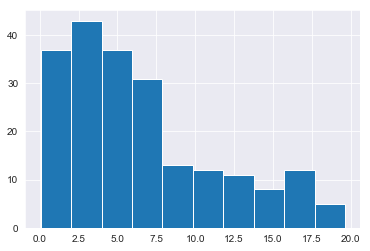

In [41]:
model_df[model_df['Total_weight_(kg)'] < 20]['Total_weight_(kg)'].hist();

In [42]:
print('Old length:', len(model_df))
print('New length:', len(model_df[model_df['Total_weight_(kg)'] < 20]))
model_df = model_df[model_df['Total_weight_(kg)'] < 20]
model_df.describe()

Old length: 231
New length: 209


ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight_(kg)  energy_kWh_per_kg  total_energy_kWh   cardboard       paper         eps  plastic_bags  flexibles_film  other_plastic        jars        food    textiles  other_organics  aluminium_cans  steel_cans         lpb          pp  pet_bottles     nappies  aluminium_recyclable   batteries       other
count  209.000000     209.000000                209.000000     209.000000        209.000000         209.000000         209.000000        209.000000  209.000000  209.000000  209.000000    209.000000      209.000000     209.000000  209.000000  209.000000  209.000000      209.000000      209.000000  209.000000  209.000000  209.000000   209.000000  209.000000            209.000000  209.000000  209.000000
mean   127.665072       0.617882                  0.073507       0.128110          0.177718           6.451358           2.129187         14.546411    0.187541    0.063856    0.015761      0.243440        0.228529       0.041775    0.041675    2.312302    0.117541        1.823627        0.666033    0.323029    0.005828    0.004957     0.181866    0.120287              0.029593    0.007656    0.036062
std     81.128357       0.351273                  0.145160       0.176516          0.242939           4.964839           1.089833         14.793311    0.447205    0.248885    0.060500      0.706067        0.393140       0.130019    0.206793    3.688316    0.511272        3.535315        1.323119    0.671666    0.040486    0.033593     0.566470    0.836878              0.195514    0.040541    0.194753
min      1.000000       0.000000                  0.000000       0.000000          0.000000           0.064000           0.000000          0.000000    0.000000    0.000000    0.000000      0.000000        0.000000       0.000000    0.000000    0.000000    0.000000        0.000000        0.000000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
25%     61.000000       0.310576                  0.000000       0.021702          0.017813           2.444000           1.350000          3.030000    0.000000    0.000000    0.000000      0.000000        0.018000       0.000000    0.000000    0.000000    0.000000        0.000000        0.000000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
50%    115.000000       0.761571                  0.006894       0.062423          0.071346           5.058000           2.730000          9.430000    0.000000    0.000000    0.000000      0.034000        0.088000       0.000000    0.000000    0.396000    0.000000        0.000000        0.118000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
75%    216.000000       0.929967                  0.066869       0.167267          0.223311           9.324000           3.030000         20.140000    0.092000    0.004000    0.000000      0.228000        0.256000       0.026000    0.000000    3.120000    0.000000        2.056000        0.490000    0.244000    0.000000    0.000000     0.196000    0.000000              0.000000    0.000000    0.000000
max    269.000000       1.000000                  0.899387       1.000000          0.972610          19.628000           3.120000         60.260000    2.352000    2.408000    0.574000      6.048000        3.228000       1.036000    2.058000   16.824000    4.376000       16.376000        8.612000    4.328000    0.532000    0.378000     6.804000   10.688000              1.840000    0.356000    2.488000

### Total Energy kWh > 0

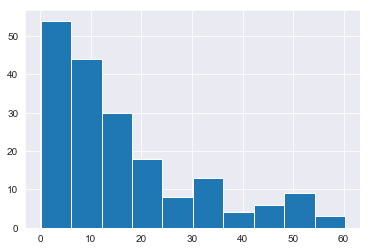

In [43]:
model_df[model_df['total_energy_kWh'] > 0]['total_energy_kWh'].hist();

In [44]:
print('Old length:', len(model_df))
print('New length:', len(model_df[model_df['total_energy_kWh'] > 0]))
model_df = model_df[model_df['total_energy_kWh'] > 0]
model_df.describe()

Old length: 209
New length: 189


ID  Organics_wt_%  Paper_and_cardboard_wt_%  Plastics_wt_%  Non_combust_wt_%  Total_weight_(kg)  energy_kWh_per_kg  total_energy_kWh   cardboard       paper         eps  plastic_bags  flexibles_film  other_plastic        jars        food    textiles  other_organics  aluminium_cans  steel_cans         lpb          pp  pet_bottles     nappies  aluminium_recyclable   batteries       other
count  189.000000     189.000000                189.000000     189.000000        189.000000         189.000000         189.000000        189.000000  189.000000  189.000000  189.000000    189.000000      189.000000     189.000000  189.000000  189.000000  189.000000      189.000000      189.000000  189.000000  189.000000  189.000000   189.000000  189.000000            189.000000  189.000000  189.000000
mean   128.412698       0.683267                  0.071043       0.101200          0.141412           6.682285           2.354497         16.085714    0.181312    0.067037    0.015386      0.209212        0.222770       0.045238    0.037651    2.556990    0.123481        2.016603        0.553233    0.267402    0.006011    0.005481     0.160392    0.133016              0.032725    0.008466    0.039878
std     82.745824       0.302667                  0.137458       0.124930          0.195764           5.008683           0.883615         14.738746    0.439127    0.260647    0.062120      0.604060        0.394057       0.136192    0.195826    3.797615    0.530299        3.665631        1.206944    0.580281    0.042180    0.035293     0.538048    0.879301              0.205400    0.042563    0.204477
min      1.000000       0.016018                  0.000000       0.000000          0.000000           0.188000           0.100000          0.070000    0.000000    0.000000    0.000000      0.000000        0.000000       0.000000    0.000000    0.000000    0.000000        0.000000        0.000000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
25%     61.000000       0.404255                  0.000000       0.019912          0.013520           2.616000           1.720000          5.320000    0.000000    0.000000    0.000000      0.000000        0.022000       0.000000    0.000000    0.000000    0.000000        0.000000        0.000000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
50%    114.000000       0.810050                  0.008187       0.057221          0.061414           5.432000           2.780000         11.750000    0.000000    0.000000    0.000000      0.028000        0.080000       0.000000    0.000000    0.748000    0.000000        0.000000        0.112000    0.000000    0.000000    0.000000     0.000000    0.000000              0.000000    0.000000    0.000000
75%    219.000000       0.939444                  0.064163       0.131185          0.174298           9.764000           3.040000         21.120000    0.092000    0.004000    0.000000      0.182000        0.254000       0.026000    0.000000    3.528000    0.000000        2.352000        0.348000    0.218000    0.000000    0.000000     0.172000    0.000000              0.000000    0.000000    0.000000
max    269.000000       1.000000                  0.823762       0.681083          0.926819          19.628000           3.120000         60.260000    2.352000    2.408000    0.574000      5.256000        3.228000       1.036000    2.058000   16.824000    4.376000       16.376000        8.612000    4.328000    0.532000    0.378000     6.804000   10.688000              1.840000    0.356000    2.488000

##  Train/Test Split

In [45]:
# X = model_df.drop(['ID',
#                    'total_energy_kWh',
#                    'energy_kWh_per_kg',
#                    'Total_weight_(kg)',
#                    'Organics_wt_%',
#                    'Paper_and_cardboard_wt_%',
#                    'Plastics_wt_%',
#                    'Non_combust_wt_%'], axis=1)
# y = model_df[['total_energy_kWh']]

In [46]:
X = model_df.drop(['ID',
                   'total_energy_kWh',
                   'energy_kWh_per_kg',
                   'Total_weight_(kg)',
                   'Organics_wt_%',
                   'Paper_and_cardboard_wt_%',
                   'Plastics_wt_%',
                   'Non_combust_wt_%'], axis=1)
y = model_df[['energy_kWh_per_kg']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [48]:
scaler = StandardScaler()
X_train_Scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_Scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

y_train_Scaled = scaler.fit_transform(y_train)
y_test_Scaled = scaler.transform(y_test)

In [49]:
X_train_Scaled.head()

cardboard     paper       eps  plastic_bags  flexibles_film  other_plastic     jars      food  textiles  other_organics  aluminium_cans  steel_cans       lpb        pp  pet_bottles   nappies  aluminium_recyclable  batteries     other
0  -0.432909 -0.288453 -0.252154     -0.337357       -0.538389      -0.173782 -0.21023  0.919986 -0.207977        0.088554       -0.334460   -0.468286 -0.155575 -0.169623    -0.286675 -0.129373             -0.151064  -0.201387 -0.263931
1  -0.432909 -0.003503 -0.252154     -0.331167       -0.318269       0.040357 -0.21023 -0.164374 -0.166670       -0.543155       -0.439572   -0.468286 -0.155575 -0.064836    -0.102801 -0.129373             -0.151064  -0.201387  1.929782
2   3.650644 -0.288453 -0.252154     -0.157831       -0.394833      -0.173782 -0.21023  2.771457 -0.207977       -0.543155        0.001270   -0.292216 -0.155575 -0.169623     0.060258 -0.129373             -0.151064   4.691903 -0.263931
3  -0.432909 -0.155476 -0.252154     -0.337357       -0.413973      -0.074949 -0.21023  0.043725 -0.207977       -0.543155       -0.406626   -0.050936 -0.155575 -0.169623    -0.286675 -0.129373             -0.151064  -0.201387 -0.263931
4  -0.432909 -0.288453 -0.252154     -0.337357       -0.490537      -0.338505 -0.21023 -0.108269 -0.207977       -0.543155       -0.466242   -0.468286 -0.155575 -0.169623    -0.286675 -0.129373             -0.151064  -0.201387 -0.263931

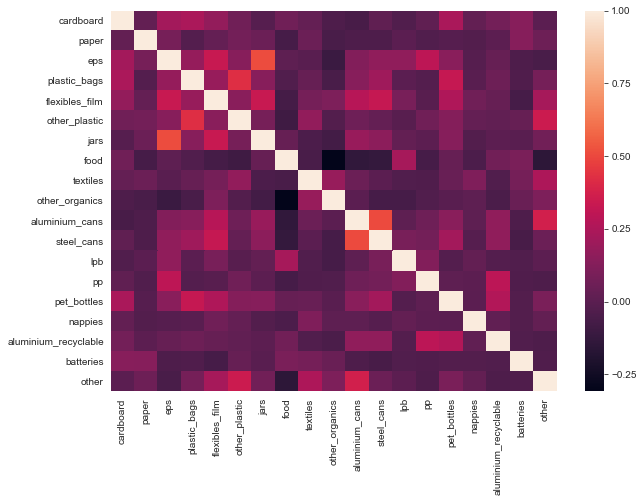

In [50]:
plt.figure(figsize=(10,7))
sns.heatmap(X_train_Scaled.corr());

In [51]:
X_train_Scaled.columns

Index(['cardboard', 'paper', 'eps', 'plastic_bags', 'flexibles_film', 'other_plastic', 'jars', 'food', 'textiles', 'other_organics', 'aluminium_cans', 'steel_cans', 'lpb', 'pp', 'pet_bottles', 'nappies', 'aluminium_recyclable', 'batteries', 'other'], dtype='object')

## Statsmodel OLS

In [52]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
plt.style.use('ggplot')

X_int = sm.tools.add_constant(X)
model = OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_kWh_per_kg   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     21.87
Date:                Tue, 27 Oct 2020   Prob (F-statistic):           5.23e-36
Time:                        11:40:53   Log-Likelihood:                -127.02
No. Observations:                 189   AIC:                             294.0
Df Residuals:                     169   BIC:                             358.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.4444      0.065     37.735      0.000       2.316       2.572
cardboard               -0.3394      0.092     -3.679      0.000      -0.522      -0.157
paper                   -0.2821      0.171     -1.654      0.100      -0.619       0.055
eps                      0.0104      0.790      0.013      0.989      -1.550       1.570
plastic_bags            -0.1632      0.073     -2.236      0.027      -0.307      -0.019
flexibles_film          -0.1010      0.113     -0.892      0.374      -0.325       0.123
other_plastic           -0.5844      0.346     -1.691      0.093      -1.267       0.098
jars                    -0.0710      0.230     -0.308      0.758      -0.525       0.383
food                     0.0835      0.011      7.651      0.000       0.062       0.105
textiles                -0.0611      0.075     -0.812      0.418      -0.210       0.087
other_organics           0.0750      0.011      6.838      0.000       0.053       0.097
aluminium_cans          -0.2476      0.037     -6.771      0.000      -0.320      -0.175
steel_cans              -0.4461      0.078     -5.702      0.000      -0.601      -0.292
lpb                     -0.3317      0.925     -0.359      0.720      -2.157       1.494
pp                      -2.0130      1.174     -1.715      0.088      -4.331       0.305
pet_bottles             -0.0508      0.077     -0.658      0.512      -0.203       0.102
nappies                  0.0677      0.044      1.548      0.123      -0.019       0.154
aluminium_recyclable     0.3344      0.224      1.494      0.137      -0.108       0.776
batteries               -1.6963      0.891     -1.905      0.059      -3.455       0.062
other                   -0.2341      0.189     -1.238      0.217      -0.607       0.139
==============================================================================
Omnibus:                       53.259   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.140
Skew:                          -1.367   Prob(JB):                     6.62e-23
Kurtosis:                       5.345   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# from statsmodels.regression.linear_model import OLS
# import statsmodels.api as sm
# import statsmodels.stats.api as sms
# import statsmodels.formula.api as smf
# import scipy.stats as stats
# plt.style.use('ggplot')

# X_int = sm.tools.add_constant(X)
# model = OLS(y, X_int).fit()
# model.summary()

In [54]:
# #
# results = []
# print('Model Residuals Plot')
# print('--------------------')
# fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
# plt.show()
# for idx, column in enumerate(X.columns):
#     print(f'Belize MSW Regression Plot for {column} Feature')
#     print('------------------------------------------------')
    
#     fig, axes = plt.subplots(figsize=(15,12))
#     fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
#     fig.tight_layout()
#     plt.show()
    
#     input('Press ENTER to continue...')

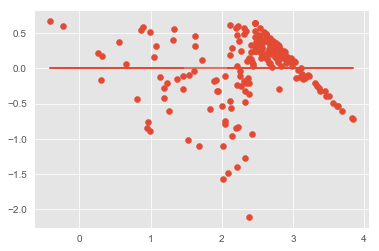

In [55]:
# Plot redisuals from Statsmodel OLS
plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_int))]);

## Scikit Learn LinearRegression Model

In [56]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train_Scaled, y_train_Scaled)

y_hat_train_scaled = linreg.predict(X_train_Scaled)
y_hat_test_scaled = linreg.predict(X_test_Scaled)

train_residuals = scaler.inverse_transform(y_hat_train_scaled) - y_train
test_residuals = scaler.inverse_transform(y_hat_test_scaled) - y_test

train_mse = mean_squared_error(y_train, scaler.inverse_transform(y_hat_train_scaled))
test_mse = mean_squared_error(y_test, scaler.inverse_transform(y_hat_test_scaled))

print('Train RMSE:', np.sqrt(train_mse))
print('------------------------------')
print('Test RMSE:', np.sqrt(test_mse))
linreg.score(X_test_Scaled, y_test_Scaled)

Train RMSE: 0.49311203013825394
------------------------------
Test RMSE: 0.5155188361636877


0.2554972897251999

Sklearn Model Intercept: [8.5148738e-17]


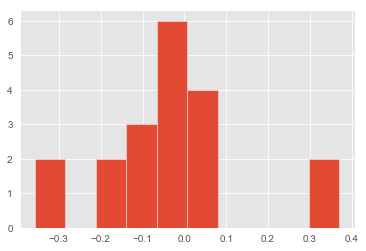

In [57]:
sklearn_results = pd.DataFrame()
sklearn_results['Item'] = [x for x in X_train_Scaled.columns]
sklearn_results['Coef'] = [x for x in linreg.coef_[0]]
print('Sklearn Model Intercept:', linreg.intercept_)
sklearn_results['Coef'].hist();

## Decision Tree Regressor

### Baseline Model

In [58]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train_Scaled, y_train_Scaled)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [59]:
from sklearn.metrics import r2_score

y_pred = regressor.predict(X_test_Scaled)
y_pred = scaler.inverse_transform(y_pred)

print('RMSE Score:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-sq Score:', r2_score(y_test, y_pred))

RMSE Score: 0.5009060755787696
R-sq Score: 0.2971060499870758


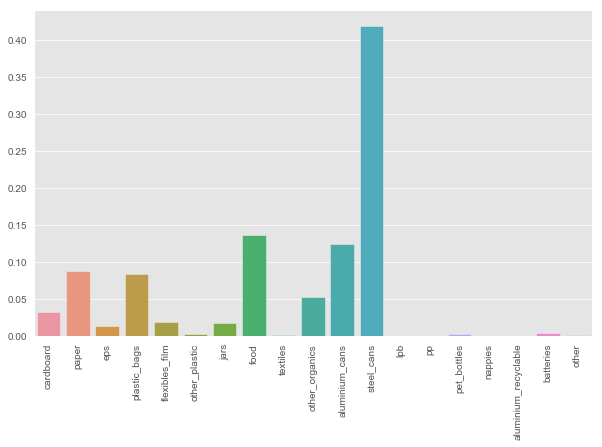

In [60]:
plt.figure(figsize=(10,6))
sns.barplot(X_train_Scaled.columns, regressor.feature_importances_, orient="v");
plt.xticks(rotation=90);

### Optimized Model

In [61]:
op_regressor = DecisionTreeRegressor(random_state=42,
                                     max_depth=4,
                                     min_samples_leaf=2,
                                     min_samples_split=4)
op_regressor.fit(X_train_Scaled, y_train_Scaled)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [62]:
y_pred = op_regressor.predict(X_test_Scaled)
y_pred = scaler.inverse_transform(y_pred)

print('RMSE Score:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-sq Score:', r2_score(y_test, y_pred))

RMSE Score: 0.5334982641095211
R-sq Score: 0.2026605947509954


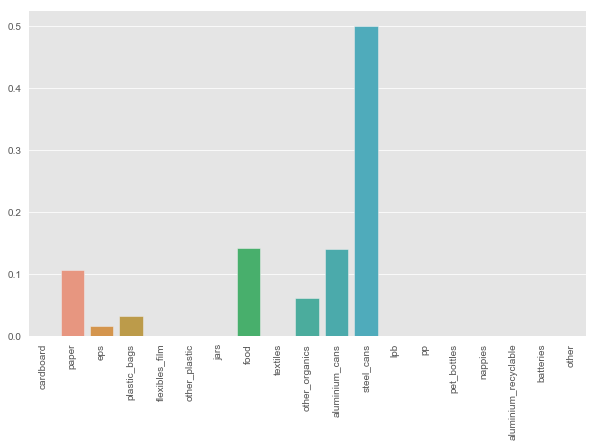

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(X_train_Scaled.columns, op_regressor.feature_importances_, orient="v");
plt.xticks(rotation=90);

## Random Forest Model

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data
import pydotplus
from sklearn.pipeline import Pipeline

### Baseline Model

In [65]:
rdm_forest = RandomForestRegressor(200, random_state=42)

In [66]:
rdm_forest.fit(X_train_Scaled, y_train_Scaled)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
rdm_forest.score(X_train_Scaled, y_train_Scaled)

0.9588947741624982

In [68]:
rdm_forest.score(X_test_Scaled, y_test_Scaled)

0.6386141556903007

In [69]:
y_preds = rdm_forest.predict(X_test_Scaled)
y_preds

array([ 0.3905369 ,  0.87275252,  0.62458936,  0.57010787,  0.53758243,
        0.37163183,  0.26157923,  0.47890587,  0.85586326, -0.82668842,
        0.68735203, -1.40381079, -0.99312936,  0.87297044,  0.42611331,
        0.20889563, -0.75618938,  0.3793682 ,  0.4808672 ,  0.87416904,
        0.50527491, -1.09708003, -0.1547138 , -0.27010558, -0.18015665,
        0.15490448,  0.86349067,  0.87629381,  0.0441981 ])

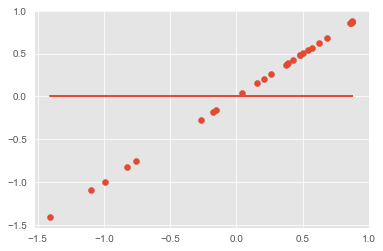

In [70]:
# Plot redisuals from Random Forest
plt.scatter(rdm_forest.predict(X_test_Scaled), y_preds)
plt.plot(rdm_forest.predict(X_test_Scaled), [0 for i in range(len(X_test_Scaled))]);

### GridSearch CV

In [71]:
rf_grid_reg = RandomForestRegressor(random_state=42)
grid_param = [{'n_estimators': [200, 250, 300],
               'max_depth': [15, 17, 20],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1, 2]}]

In [72]:
# rf_gridsearch = GridSearchCV(rf_grid_reg, grid_param, cv=3)
# rf_gridsearch.fit(X_train_Scaled, y_train_Scaled)

In [73]:
# rf_gridsearch.best_params_

In [74]:
# rf_gridsearch.score(X_test_Scaled, y_test_Scaled)

In [75]:
optimal_rf_model = RandomForestRegressor(max_depth=17,
                                         min_samples_leaf=1,
                                         min_samples_split=3,
                                         n_estimators=250,
                                         random_state=42)
optimal_rf_model.fit(X_train_Scaled, y_train_Scaled)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

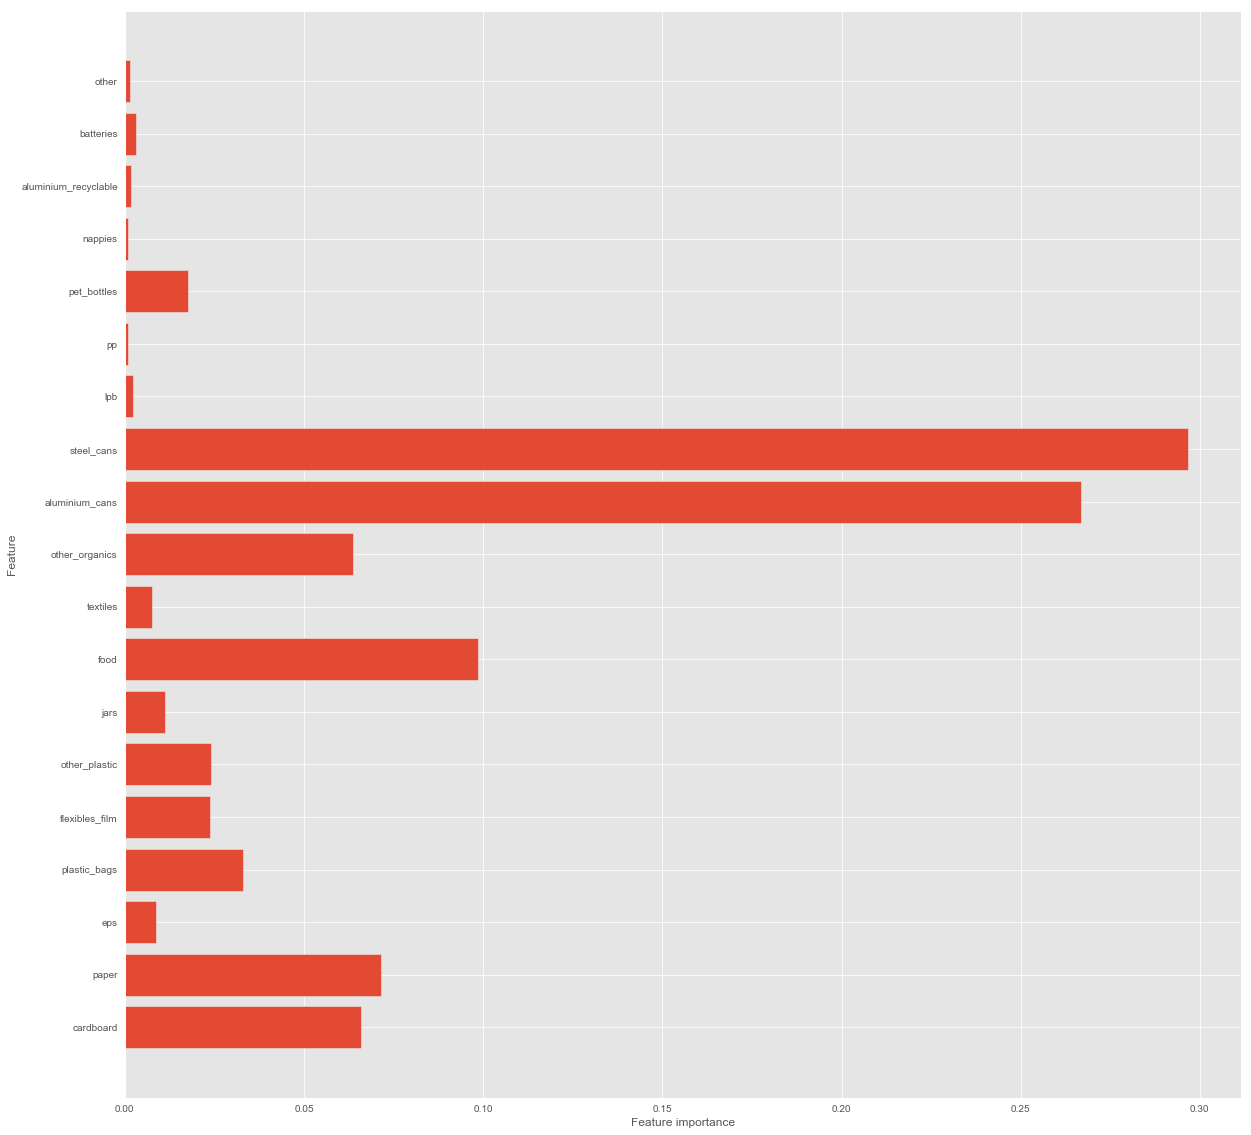

In [76]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(optimal_rf_model)

## MLP Regression Model

In [77]:
from keras import layers, models, optimizers, regularizers
from keras import backend as K
from keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor

In [78]:
n_features = X_train_Scaled.shape[1]

### Loss, MSE, & R^2 Visualization Function

In [79]:
def coef_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [80]:
#Build vizualization function for training/validation loss and accuracy
def visualize_loss_MSE(results):
    history = results.history
    
    plt.plot(history['loss'], 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(history['mse'], 'b', label='Training MSE')
    plt.title('Training MSE')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(history['coef_determination'], 'b', label='Training R^2')
    plt.title('Training R^2')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('R^2', fontsize=12)
    plt.legend(loc='best')
    plt.show()

### Baseline Model

In [81]:
baseline_model = Sequential()

baseline_model.add(layers.Dense(10, activation='relu', input_shape=(n_features, )))

baseline_model.add(layers.Dense(5, activation='relu'))

baseline_model.add(layers.Dense(1, activation='linear'))

baseline_model.compile(optimizer='SGD',
              loss='mse',
              metrics=['mse', coef_determination])


In [82]:
baseline_model.fit(X_train_Scaled,
                  y_train_Scaled,
                  epochs=150)

Epoch 1/150
5/5 [==============================] - 0s 598us/step - loss: 1.3100 - mse: 1.3100 - coef_determination: -0.3528
Epoch 2/150
5/5 [==============================] - 0s 595us/step - loss: 1.1356 - mse: 1.1356 - coef_determination: -0.1730
Epoch 3/150
5/5 [==============================] - 0s 800us/step - loss: 1.0174 - mse: 1.0174 - coef_determination: -0.0773
Epoch 4/150
5/5 [==============================] - 0s 798us/step - loss: 0.9397 - mse: 0.9397 - coef_determination: 0.0502
Epoch 5/150
5/5 [==============================] - 0s 600us/step - loss: 0.8776 - mse: 0.8776 - coef_determination: 0.1064
Epoch 6/150
5/5 [==============================] - 0s 799us/step - loss: 0.8272 - mse: 0.8272 - coef_determination: 0.1711
Epoch 7/150
5/5 [==============================] - 0s 798us/step - loss: 0.7814 - mse: 0.7814 - coef_determination: 0.1995
Epoch 8/150
5/5 [==============================] - 0s 595us/step - loss: 0.7443 - mse: 0.7443 - coef_determination: 0.2526
Epoch 9/150
5

5/5 [==============================] - 0s 598us/step - loss: 0.2300 - mse: 0.2300 - coef_determination: 0.7699
Epoch 67/150
5/5 [==============================] - 0s 598us/step - loss: 0.2293 - mse: 0.2293 - coef_determination: 0.7535
Epoch 68/150
5/5 [==============================] - 0s 599us/step - loss: 0.2259 - mse: 0.2259 - coef_determination: 0.7749
Epoch 69/150
5/5 [==============================] - 0s 598us/step - loss: 0.2239 - mse: 0.2239 - coef_determination: 0.7783
Epoch 70/150
5/5 [==============================] - 0s 598us/step - loss: 0.2226 - mse: 0.2226 - coef_determination: 0.7721
Epoch 71/150
5/5 [==============================] - 0s 598us/step - loss: 0.2212 - mse: 0.2212 - coef_determination: 0.7542
Epoch 72/150
5/5 [==============================] - 0s 598us/step - loss: 0.2198 - mse: 0.2198 - coef_determination: 0.7845
Epoch 73/150
5/5 [==============================] - 0s 598us/step - loss: 0.2176 - mse: 0.2176 - coef_determination: 0.7793
Epoch 74/150
5/5 [===

5/5 [==============================] - 0s 798us/step - loss: 0.1613 - mse: 0.1613 - coef_determination: 0.8322
Epoch 132/150
5/5 [==============================] - 0s 798us/step - loss: 0.1598 - mse: 0.1598 - coef_determination: 0.8380
Epoch 133/150
5/5 [==============================] - 0s 599us/step - loss: 0.1594 - mse: 0.1594 - coef_determination: 0.8372
Epoch 134/150
5/5 [==============================] - 0s 798us/step - loss: 0.1596 - mse: 0.1596 - coef_determination: 0.8395
Epoch 135/150
5/5 [==============================] - 0s 798us/step - loss: 0.1575 - mse: 0.1575 - coef_determination: 0.8388
Epoch 136/150
5/5 [==============================] - 0s 798us/step - loss: 0.1574 - mse: 0.1574 - coef_determination: 0.8432
Epoch 137/150
5/5 [==============================] - 0s 598us/step - loss: 0.1572 - mse: 0.1572 - coef_determination: 0.8366
Epoch 138/150
5/5 [==============================] - 0s 599us/step - loss: 0.1563 - mse: 0.1563 - coef_determination: 0.8383
Epoch 139/150


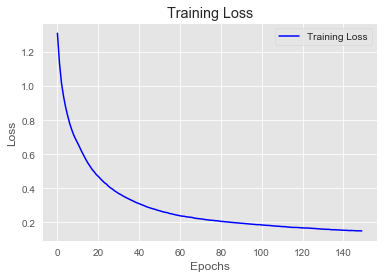

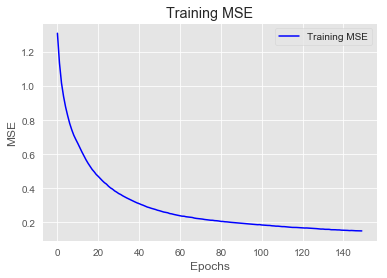

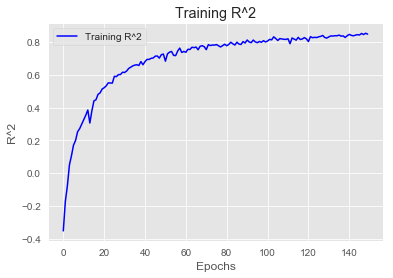

In [83]:
visualize_loss_MSE(baseline_model.history)

In [84]:
baseline_preds_scaled = baseline_model.predict(X_test_Scaled)
baseline_preds = scaler.inverse_transform(baseline_preds_scaled)
rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

print('RMSE:', rmse)
print('-------------------------')
print(baseline_model.summary())

RMSE: 1.1364922569360725
-------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
None


### Overfit Model

In [85]:
overfit_model = Sequential()

overfit_model.add(layers.Dense(10, activation='relu', input_shape=(n_features, )))

overfit_model.add(layers.Dense(10, activation='relu'))

overfit_model.add(layers.Dense(10, activation='relu'))

overfit_model.add(layers.Dense(10, activation='relu'))

overfit_model.add(layers.Dense(1, activation='linear'))

overfit_model.compile(optimizer='SGD',
              loss='mse',
              metrics=['mse', coef_determination])


In [86]:
overfit_model.fit(X_train_Scaled,
                  y_train_Scaled,
                  epochs=150,
                  batch_size=10)

Epoch 1/150
16/16 [==============================] - 0s 686us/step - loss: 1.2633 - mse: 1.2633 - coef_determination: -0.4189
Epoch 2/150
16/16 [==============================] - 0s 623us/step - loss: 1.0595 - mse: 1.0595 - coef_determination: -0.2884
Epoch 3/150
16/16 [==============================] - 0s 810us/step - loss: 0.9974 - mse: 0.9974 - coef_determination: -0.6985
Epoch 4/150
16/16 [==============================] - 0s 685us/step - loss: 0.9458 - mse: 0.9458 - coef_determination: -0.0604
Epoch 5/150
16/16 [==============================] - 0s 686us/step - loss: 0.9042 - mse: 0.9042 - coef_determination: -0.0992
Epoch 6/150
16/16 [==============================] - 0s 686us/step - loss: 0.8671 - mse: 0.8671 - coef_determination: -0.0288
Epoch 7/150
16/16 [==============================] - 0s 561us/step - loss: 0.8192 - mse: 0.8192 - coef_determination: 0.0932
Epoch 8/150
16/16 [==============================] - 0s 561us/step - loss: 0.7719 - mse: 0.7719 - coef_determination: 0

16/16 [==============================] - 0s 623us/step - loss: 0.1178 - mse: 0.1178 - coef_determination: 0.8525
Epoch 67/150
16/16 [==============================] - 0s 561us/step - loss: 0.1164 - mse: 0.1164 - coef_determination: 0.8394
Epoch 68/150
16/16 [==============================] - 0s 634us/step - loss: 0.1134 - mse: 0.1134 - coef_determination: 0.8675
Epoch 69/150
16/16 [==============================] - 0s 624us/step - loss: 0.1141 - mse: 0.1141 - coef_determination: 0.8780
Epoch 70/150
16/16 [==============================] - 0s 686us/step - loss: 0.1118 - mse: 0.1118 - coef_determination: 0.8752
Epoch 71/150
16/16 [==============================] - 0s 748us/step - loss: 0.1138 - mse: 0.1138 - coef_determination: 0.8668
Epoch 72/150
16/16 [==============================] - 0s 748us/step - loss: 0.1128 - mse: 0.1128 - coef_determination: 0.8840
Epoch 73/150
16/16 [==============================] - 0s 688us/step - loss: 0.1108 - mse: 0.1108 - coef_determination: 0.8756
Epoch

16/16 [==============================] - 0s 684us/step - loss: 0.0721 - mse: 0.0721 - coef_determination: 0.9285
Epoch 131/150
16/16 [==============================] - 0s 623us/step - loss: 0.0720 - mse: 0.0720 - coef_determination: 0.9146
Epoch 132/150
16/16 [==============================] - 0s 619us/step - loss: 0.0770 - mse: 0.0770 - coef_determination: 0.8191
Epoch 133/150
16/16 [==============================] - 0s 685us/step - loss: 0.0747 - mse: 0.0747 - coef_determination: 0.8662
Epoch 134/150
16/16 [==============================] - 0s 683us/step - loss: 0.0764 - mse: 0.0764 - coef_determination: 0.8754
Epoch 135/150
16/16 [==============================] - 0s 561us/step - loss: 0.0737 - mse: 0.0737 - coef_determination: 0.9142
Epoch 136/150
16/16 [==============================] - 0s 685us/step - loss: 0.0709 - mse: 0.0709 - coef_determination: 0.9272
Epoch 137/150
16/16 [==============================] - 0s 686us/step - loss: 0.0724 - mse: 0.0724 - coef_determination: 0.904

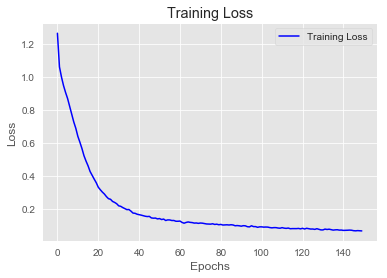

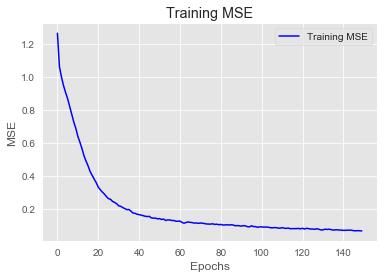

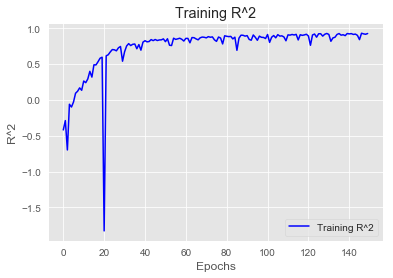

In [87]:
visualize_loss_MSE(overfit_model.history)

In [88]:
overfit_preds_scaled = overfit_model.predict(X_test_Scaled)
overfit_preds = scaler.inverse_transform(overfit_preds_scaled)
rmse = np.sqrt(mean_squared_error(y_test, overfit_preds))

print('RMSE:', rmse)
print('-------------------------')
print(overfit_model.summary())

RMSE: 0.7716757137330256
-------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                200       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
None


### Regularized Model

In [89]:
reg_model = Sequential()

reg_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(0.005),
                           activation='relu', input_shape=(n_features, )))

reg_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(0.005),
                           activation='relu'))

reg_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(0.005),
                           activation='relu'))

reg_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(0.005),
                           activation='relu'))

reg_model.add(layers.Dense(10, kernel_regularizer=regularizers.L2(0.005),
                           activation='relu'))

reg_model.add(layers.Dense(1, activation='linear'))

reg_model.compile(optimizer='SGD',
              loss='mse',
              metrics=['mse', coef_determination])


In [90]:
reg_model.fit(X_train_Scaled,
                  y_train_Scaled,
                  epochs=150)

Epoch 1/150
5/5 [==============================] - 0s 798us/step - loss: 1.2347 - mse: 0.9845 - coef_determination: -0.0131
Epoch 2/150
5/5 [==============================] - 0s 800us/step - loss: 1.2272 - mse: 0.9773 - coef_determination: 0.0128
Epoch 3/150
5/5 [==============================] - 0s 599us/step - loss: 1.2227 - mse: 0.9730 - coef_determination: 0.0073
Epoch 4/150
5/5 [==============================] - 0s 799us/step - loss: 1.2179 - mse: 0.9683 - coef_determination: 0.0206
Epoch 5/150
5/5 [==============================] - 0s 798us/step - loss: 1.2134 - mse: 0.9641 - coef_determination: 0.0193
Epoch 6/150
5/5 [==============================] - 0s 997us/step - loss: 1.2093 - mse: 0.9601 - coef_determination: -0.0108
Epoch 7/150
5/5 [==============================] - 0s 798us/step - loss: 1.2052 - mse: 0.9562 - coef_determination: -0.0234
Epoch 8/150
5/5 [==============================] - 0s 599us/step - loss: 1.1985 - mse: 0.9497 - coef_determination: 0.0401
Epoch 9/150
5

5/5 [==============================] - 0s 805us/step - loss: 0.5186 - mse: 0.2706 - coef_determination: 0.7247
Epoch 68/150
5/5 [==============================] - 0s 798us/step - loss: 0.5171 - mse: 0.2693 - coef_determination: 0.7248
Epoch 69/150
5/5 [==============================] - 0s 799us/step - loss: 0.5119 - mse: 0.2641 - coef_determination: 0.7241
Epoch 70/150
5/5 [==============================] - 0s 791us/step - loss: 0.5079 - mse: 0.2604 - coef_determination: 0.7183
Epoch 71/150
5/5 [==============================] - 0s 798us/step - loss: 0.5067 - mse: 0.2591 - coef_determination: 0.7185
Epoch 72/150
5/5 [==============================] - 0s 793us/step - loss: 0.5037 - mse: 0.2564 - coef_determination: 0.7307
Epoch 73/150
5/5 [==============================] - 0s 805us/step - loss: 0.4993 - mse: 0.2521 - coef_determination: 0.7467
Epoch 74/150
5/5 [==============================] - 0s 787us/step - loss: 0.4978 - mse: 0.2508 - coef_determination: 0.7441
Epoch 75/150
5/5 [===

5/5 [==============================] - 0s 598us/step - loss: 0.3989 - mse: 0.1595 - coef_determination: 0.8403
Epoch 133/150
5/5 [==============================] - 0s 798us/step - loss: 0.4007 - mse: 0.1615 - coef_determination: 0.8355
Epoch 134/150
5/5 [==============================] - 0s 797us/step - loss: 0.3998 - mse: 0.1608 - coef_determination: 0.8236
Epoch 135/150
5/5 [==============================] - 0s 798us/step - loss: 0.3972 - mse: 0.1583 - coef_determination: 0.8432
Epoch 136/150
5/5 [==============================] - 0s 798us/step - loss: 0.3949 - mse: 0.1560 - coef_determination: 0.8426
Epoch 137/150
5/5 [==============================] - 0s 808us/step - loss: 0.3946 - mse: 0.1559 - coef_determination: 0.8347
Epoch 138/150
5/5 [==============================] - 0s 800us/step - loss: 0.3940 - mse: 0.1554 - coef_determination: 0.8409
Epoch 139/150
5/5 [==============================] - 0s 794us/step - loss: 0.3936 - mse: 0.1551 - coef_determination: 0.8405
Epoch 140/150


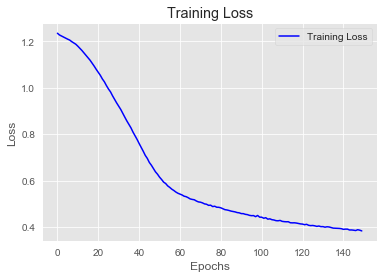

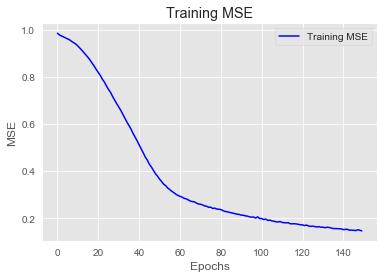

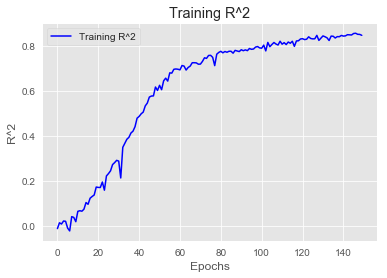

In [91]:
visualize_loss_MSE(reg_model.history)

In [92]:
reg_preds_scaled = reg_model.predict(X_test_Scaled)
reg_preds = scaler.inverse_transform(reg_preds_scaled)
rmse = np.sqrt(mean_squared_error(y_test, reg_preds))

print('RMSE:', rmse)
print('-------------------------')
print(reg_model.summary())

RMSE: 0.4660846228604259
-------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                200       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_____

### Optimized Model

In [93]:
otptimized_model = Sequential()

otptimized_model.add(layers.Dense(35,
                                  kernel_regularizer=regularizers.L2(0.005),
                           activation='relu', input_shape=(n_features, )))

otptimized_model.add(layers.Dense(15,
                                  kernel_regularizer=regularizers.L2(0.005),
                           activation='relu'))

otptimized_model.add(layers.Dense(3,
                                  kernel_regularizer=regularizers.L2(0.005),
                           activation='relu'))

otptimized_model.add(layers.Dense(1, activation='linear'))

otptimized_model.compile(optimizer='RMSprop',
              loss='mse',
              metrics=['mse', coef_determination])

In [94]:
otptimized_model.fit(X_train_Scaled,
                     y_train_Scaled,
                     epochs=150)

Epoch 1/150
5/5 [==============================] - 0s 998us/step - loss: 1.2963 - mse: 1.0412 - coef_determination: -0.0801
Epoch 2/150
5/5 [==============================] - 0s 798us/step - loss: 1.1368 - mse: 0.8843 - coef_determination: 0.0726
Epoch 3/150
5/5 [==============================] - 0s 798us/step - loss: 1.0347 - mse: 0.7839 - coef_determination: 0.1874
Epoch 4/150
5/5 [==============================] - 0s 798us/step - loss: 0.9567 - mse: 0.7073 - coef_determination: 0.2820
Epoch 5/150
5/5 [==============================] - 0s 999us/step - loss: 0.8976 - mse: 0.6492 - coef_determination: 0.3107
Epoch 6/150
5/5 [==============================] - 0s 798us/step - loss: 0.8546 - mse: 0.6074 - coef_determination: 0.2981
Epoch 7/150
5/5 [==============================] - 0s 798us/step - loss: 0.8190 - mse: 0.5731 - coef_determination: 0.4089
Epoch 8/150
5/5 [==============================] - 0s 806us/step - loss: 0.7868 - mse: 0.5420 - coef_determination: 0.4361
Epoch 9/150
5/5

5/5 [==============================] - 0s 798us/step - loss: 0.2351 - mse: 0.0737 - coef_determination: 0.9266
Epoch 68/150
5/5 [==============================] - 0s 789us/step - loss: 0.2342 - mse: 0.0740 - coef_determination: 0.9267
Epoch 69/150
5/5 [==============================] - 0s 602us/step - loss: 0.2324 - mse: 0.0734 - coef_determination: 0.9309
Epoch 70/150
5/5 [==============================] - 0s 608us/step - loss: 0.2319 - mse: 0.0740 - coef_determination: 0.9221
Epoch 71/150
5/5 [==============================] - 0s 798us/step - loss: 0.2293 - mse: 0.0725 - coef_determination: 0.9299
Epoch 72/150
5/5 [==============================] - 0s 598us/step - loss: 0.2272 - mse: 0.0716 - coef_determination: 0.9268
Epoch 73/150
5/5 [==============================] - 0s 599us/step - loss: 0.2252 - mse: 0.0707 - coef_determination: 0.9255
Epoch 74/150
5/5 [==============================] - 0s 798us/step - loss: 0.2235 - mse: 0.0701 - coef_determination: 0.9337
Epoch 75/150
5/5 [===

5/5 [==============================] - 0s 601us/step - loss: 0.1633 - mse: 0.0556 - coef_determination: 0.9405
Epoch 133/150
5/5 [==============================] - 0s 788us/step - loss: 0.1659 - mse: 0.0587 - coef_determination: 0.9254
Epoch 134/150
5/5 [==============================] - 0s 801us/step - loss: 0.1633 - mse: 0.0566 - coef_determination: 0.9443
Epoch 135/150
5/5 [==============================] - 0s 799us/step - loss: 0.1648 - mse: 0.0586 - coef_determination: 0.9448
Epoch 136/150
5/5 [==============================] - 0s 795us/step - loss: 0.1634 - mse: 0.0577 - coef_determination: 0.9460
Epoch 137/150
5/5 [==============================] - 0s 797us/step - loss: 0.1594 - mse: 0.0542 - coef_determination: 0.9473
Epoch 138/150
5/5 [==============================] - 0s 798us/step - loss: 0.1594 - mse: 0.0547 - coef_determination: 0.9373
Epoch 139/150
5/5 [==============================] - 0s 798us/step - loss: 0.1593 - mse: 0.0551 - coef_determination: 0.9496
Epoch 140/150


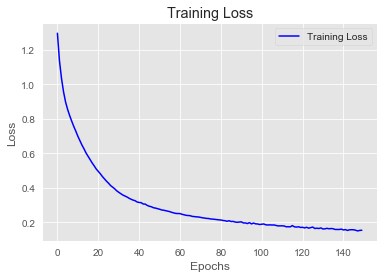

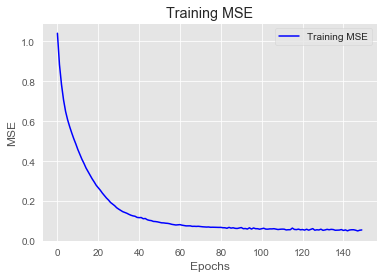

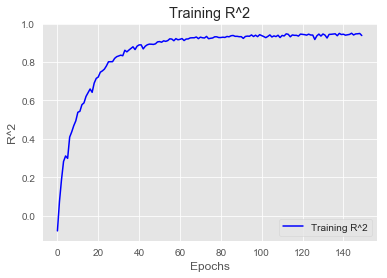

In [95]:
visualize_loss_MSE(otptimized_model.history)

In [96]:
op_preds_scaled = otptimized_model.predict(X_test_Scaled)
op_preds = scaler.inverse_transform(op_preds_scaled)
rmse = np.sqrt(mean_squared_error(y_test, op_preds))

print('RMSE:', rmse)
print('-------------------------')
print(otptimized_model.summary())

RMSE: 0.2583515463010443
-------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 35)                700       
_________________________________________________________________
dense_15 (Dense)             (None, 15)                540       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 48        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 4         
Total params: 1,292
Trainable params: 1,292
Non-trainable params: 0
_________________________________________________________________
None
